# Helper Functions Volume 4: Feature Engineering & Model preparation

Author: Koh Kok Bin  
Date: 17 Feb 2022

This notebook provides some basic walkthroughs on how best to optimize features (aka parameters or x 'predictor' variables). It is not meant to be exhaustive but should cover most of what is done during data science projects.

### <a id = "VOL4_toc"> Table of contents:  </a>
- [Reference Materials -- This needs to be run so that Parts 1 to n can work.](#VOL4_refmat)  
- [Feature selection -- Which variable is redundant?](#VOL4_feat_select)  
- [Feature Engineering -- How best to convert the variables so models can accept it?]
- [Train/test split, stratified sampling]  


The generic idea is tho perform feature engineering to ensure table is rid of unnecessary data, and is in a format that can be easily interpreted (accurately) by the model itself. Only when that is done, the pre-model preparation like train/test split etc should be performed. 

In [4]:
import os
import pandas as pd

In [5]:
# Get directory name of this file. Helpful to specify the directory of the file, 
# so you can also interact with the files in the same location via relative paths.

dirname = globals()["_dh"][0]

In [6]:
data_folder = "VOL4"
list_of_files = os.listdir(os.path.join(dirname, data_folder)) # Absolute path
list_of_files2 = os.listdir(data_folder) # Relative path

# They are the same; only 1 file in folder
list_of_files == list_of_files2

True

In [7]:
# Replace function is meant to ensure sharepoint files will work.
# This code is more readable too.
datafile = os.path.join(dirname, data_folder, list_of_files[0]).replace("\\", "/")
df = pd.read_csv(datafile)

In [8]:
df2 = df.copy()

In [9]:
df2.head(2)

,month,town,flat_type,block,street_name,storey_range,floor_area_sqm,flat_model,lease_commence_date,remaining_lease,resale_price
0,2017-01,ANG MO KIO,2 ROOM,406,ANG MO KIO AVE 10,10 TO 12,44.0,Improved,1979,61 years 04 months,232000.0
1,2017-01,ANG MO KIO,3 ROOM,108,ANG MO KIO AVE 4,01 TO 03,67.0,New Generation,1978,60 years 07 months,250000.0


In [10]:
# Conduct preliminary processing, aka the usual ones done in the earlier helper volumes
df2.columns = map(str.upper, df2.columns)

In [11]:
df2.columns

Index(['MONTH', 'TOWN', 'FLAT_TYPE', 'BLOCK', 'STREET_NAME', 'STOREY_RANGE',
       'FLOOR_AREA_SQM', 'FLAT_MODEL', 'LEASE_COMMENCE_DATE',
       'REMAINING_LEASE', 'RESALE_PRICE'],
      dtype='object')

### <a id = "VOL4_feat_select"> Feature Selection </a>  

This step is not heavily discussed, but makes sense. In machine learning and in life, we deal with noise all the time. Only a few signals matter and its important to tune out the noise. For datasets that have many columns, choosing the relevant ones to build the model will improve your model by a great extent. Your model will assume all features being provided *are* important.

We know that from experience (or domain knowledge), only a few things matter to prices of resale transactions. For example, the floor level, location (e.g. Tengah or Bishan), size (2/3/4/5 room), remaining lease (94 years vs 60 years). In our HDB dataset, there are other columns like block, street_name. While we inherently know that these likely don't matter (unless your block has the number 8), we need a definitive way to conclude that such variables are not relevant in say predicting housing prices.  

#### What's the point of removing them? Just let the model figure it out?  
As above, using irrelevant variables only introduces noise in your model. More columns = longer time to train/build the model. Even then, results are often unsatistfactory (as it includes irrelevant data). The best case is that all columns are processed to some integer or float value (i.e. decimal places). However, as described in the slides, numbers imply a certain ranking/order (more on this in a later section).  

Can / should we imply a ranking/order for the block number of the flat being sold? Is block number 999 > 888? I don't think so.  

Ideally, we will perform feature engineering + selection concurrently as some of the methods used to determine statistical relevance works best on processed data (i.e. data fit for ML models).

Let's take a look at the columns individually.  

- __MONTH (20XX-YY)__: How will feeding this into the ML model be useful? What do we want to achieve? Most ML classification/regression models deal with the problem statement __"predicting Y from X at point in time".__ On the other hand, forecasting's problem statement can be approximated to __"predicting future data from time series X over time"__.  

For the purpose of this exercise, we can assume (*very big assumption*) that the entire dataset of resale transactions took place at a point in time. Otherwise, we would have to treat it like a time-series dataset which is quite complicated and often not the use case for DOS.  

- __TOWN (character/string)__: These are the values corresponding to the town that the resale transaction took place in. There are a few ways we can approach this: 1) To build individual models for each town (aka Punggol, Jurong, Boon Lay). This assumes that the resale prices across towns exhibit a different characteristic. 2) To code these towns into broader terms such as Outside Central Region (OCR), Core Central Region (CCR) and Rest of Central Region (RCR). 3) To apply one-hot encoding to the TOWN column, thereby splitting the column into 26 columns.  

Based on the current housing trend + news reports, we can probably tell that there have been a large demand flow shifting from CCR and RCR towards the suburban areas. This is probably best reflected in the resale housing index (mainly OCR regions), which has been on a steady uptrend since COVID. Furthermore, you can also deduce that housing prices between neighboorhood towns like Yishun vs Punggol (i.e. digital hub) will be different. What's the best approach here? My recommendation is to try all 3 and then compare the performance of each. This will show that you've done your analysis and background work too!  

We can start by processing these 2 columns first.

In [12]:
# Remove month column 
df2 = df2.drop(columns = "MONTH")  

# TOWN processing will be done last because 
# it requires more code to iterate over 3 datasets to process other columns.

In [13]:
df2["FLAT_TYPE"].unique()

array(['2 ROOM', '3 ROOM', '4 ROOM', '5 ROOM', 'EXECUTIVE', '1 ROOM',
       'MULTI-GENERATION'], dtype=object)

- __FLAT_TYPE (Character/String)__: This column is straightforward. Generally speaking, holding psf constant, Multi-generation flats are larger than Executive flats. Executive > 5 room > 4 Room > 3 Room > 2 Room > 1 Room. There is a clear order for this column, and so it makes sense to convert it to a number where the model knows that larger numbers (i.e. FLAT_TYPE) are 'correlated' with higher prices.

In [14]:
# 2 methods below that produces the same result
from sklearn import preprocessing

In [15]:
# Ranking is set out here. 1 room is given a 'score' of 0, and multi-gen has the highest score: 5
ranking = ["1 ROOM", "2 ROOM", "3 ROOM", "4 ROOM", "5 ROOM", "EXECUTIVE", "MULTI-GENERATION"]
score = [x for x in range(len(ranking))]
flat_dict = {k:v for k, v in zip(ranking, score)}

df3 = df2.copy()
#df3["FLAT_TYPE"] = df3["FLAT_TYPE"].replace(flat_dict)

In [16]:
test = list(df3["FLAT_TYPE"].replace(flat_dict))

# Label Encoder is a 2 step process.
# First, create the LabelEncoder object.
label_enc = preprocessing.LabelEncoder()

# Next, fit the ranking to the label. It will parse the elements into scores based on element order.
# 1 ROOM = 0, 2 ROOM = 1
# transform will convert the dataset from the 1 Room labels into integers 0 - n
test2 = list(label_enc.fit(ranking).transform(list(df3["FLAT_TYPE"])))

# Compare equality. True
test == test2
#df2["FLAT_TYPE"].replace(flat_dict)

True

In [17]:
df3["FLAT_TYPE"] = list(label_enc.fit(ranking).transform(list(df3["FLAT_TYPE"])))

In [18]:
df3.head(2) 

,TOWN,FLAT_TYPE,BLOCK,STREET_NAME,STOREY_RANGE,FLOOR_AREA_SQM,FLAT_MODEL,LEASE_COMMENCE_DATE,REMAINING_LEASE,RESALE_PRICE
0,ANG MO KIO,1,406,ANG MO KIO AVE 10,10 TO 12,44.0,Improved,1979,61 years 04 months,232000.0
1,ANG MO KIO,2,108,ANG MO KIO AVE 4,01 TO 03,67.0,New Generation,1978,60 years 07 months,250000.0


- __BLOCK (Character/String)__: This column is by right an integer column. However, there are new blocks that have block numbers ending with alphabets (e.g. 103A). In any case, for many of these columns there's no real need to test for statistical signficance (i.e. based on chi-squared test and the like). This is because they are already deemed to be irrelevant based on domain knowledge.  

- __STREET_NAME (Character/String)__: This column is also quite irrelevant unless you have resources available to mine further for insights. For example, if you could use the BLOCK + STREET_NAME columns to identify the postal code and subsequently the longitude and latitude of the transaction, you are able to derive a particular resale transaction's proximity to the nearest MRT. The distance can be fed into the model to see if it yields better performance.  

*If you would like to try, google these 2 terms: OneMAP API by SLA, python implementation of Haversine formula.*  
 
For this project, we assume these 2 columns are irrelevant and will remove them.

In [19]:
df3 = df3.drop(columns = ["BLOCK", "STREET_NAME"])

In [20]:
df3.head(2)

,TOWN,FLAT_TYPE,STOREY_RANGE,FLOOR_AREA_SQM,FLAT_MODEL,LEASE_COMMENCE_DATE,REMAINING_LEASE,RESALE_PRICE
0,ANG MO KIO,1,10 TO 12,44.0,Improved,1979,61 years 04 months,232000.0
1,ANG MO KIO,2,01 TO 03,67.0,New Generation,1978,60 years 07 months,250000.0


- __STOREY_RANGE (Character/String)__: This column tells you the floor on which the resale flat is sold. For simplicity, as they are in range of 3 floors (01 TO 03), we can simply take the middle floor. Since floor numbers are integer, we have already implicitly imply that this column is ranked and higher floors generally have a higher resale price (as they usually do).

In [21]:
def get_mid(floors, mysplit = " TO "):
    return int((int(floors.split(mysplit)[0]) + int(floors.split(mysplit)[1]))/2)

df3["STOREY_RANGE"] = df3["STOREY_RANGE"].apply(get_mid)

In [22]:
# Levels 2 to 50, by 3
df3["STOREY_RANGE"].unique()

array([11,  2,  5,  8, 14, 20, 23, 17, 35, 29, 38, 50, 26, 41, 32, 47, 44],
      dtype=int64)

In [23]:
df3.head(2)

,TOWN,FLAT_TYPE,STOREY_RANGE,FLOOR_AREA_SQM,FLAT_MODEL,LEASE_COMMENCE_DATE,REMAINING_LEASE,RESALE_PRICE
0,ANG MO KIO,1,11,44.0,Improved,1979,61 years 04 months,232000.0
1,ANG MO KIO,2,2,67.0,New Generation,1978,60 years 07 months,250000.0


- __FLOOR_AREA_SQM (Float)__: This column is self explanatory. No processing is needed.

- __FLAT_MODEL (Character/String)__: This column lists the different kind of models for each type of flat. There are quite a few models over the years, and documentation on such models are sparse. Again, we can choose to remove it entirely, but based on the terms like "Premium Apartment Loft" or "Adjoined flat" or "Premium Maisonette", I think there may be some causal effect with flat models and resale prices. However, unless there's clear documentation on the kinds of models, we should think twice about using label encoding to rank the different models. The last option would therefore be to implement one-hot encoding.  

There is a tradeoff regarding the size of the final dataset. The dataset has about 110k rows. To create another 19 columns may adversely impact your project processes. Below I will provide examples on how to perform one-hot encoding via one-liners. For this project, we will not use one-hot encoding on the FLAT_MODEL column. As such, we will remove it.

In [24]:
df3["FLAT_MODEL"].value_counts()

Model A                   37626
Improved                  28655
New Generation            14856
Premium Apartment         13128
Apartment                  4609
Simplified                 4507
Maisonette                 3463
Standard                   3252
DBSS                       2176
Model A2                   1359
Adjoined flat               217
Type S1                     207
Model A-Maisonette          205
Type S2                     118
Terrace                      72
Premium Apartment Loft       72
Multi Generation             58
Improved-Maisonette          18
2-room                       14
Premium Maisonette           11
Name: FLAT_MODEL, dtype: int64

In [31]:
# Method 0
oh_enc = preprocessing.OneHotEncoder()

# Will only be done on first 100 rows. Otherwise will be slow.
# Of course, if there are more rows, there will be more elements in each array (due to different values)
# These can be converted to columns (i.e. 1st column = 1st element of each array)
test = oh_enc.fit_transform(df3[["FLAT_MODEL"]]).toarray()
print(test[0:5])

[[0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]]


In [32]:
# Method 1 - outputs 20 columns
# This is simpler to use. However, do note the larger the dataset, the longer it takes to process.
# pd.get_dummies is the method to use. 
pd.get_dummies(df3["FLAT_MODEL"]).info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 114623 entries, 0 to 114622
Data columns (total 20 columns):
2-room                    114623 non-null uint8
Adjoined flat             114623 non-null uint8
Apartment                 114623 non-null uint8
DBSS                      114623 non-null uint8
Improved                  114623 non-null uint8
Improved-Maisonette       114623 non-null uint8
Maisonette                114623 non-null uint8
Model A                   114623 non-null uint8
Model A-Maisonette        114623 non-null uint8
Model A2                  114623 non-null uint8
Multi Generation          114623 non-null uint8
New Generation            114623 non-null uint8
Premium Apartment         114623 non-null uint8
Premium Apartment Loft    114623 non-null uint8
Premium Maisonette        114623 non-null uint8
Simplified                114623 non-null uint8
Standard                  114623 non-null uint8
Terrace                   114623 non-null uint8
Type S1                  

In [52]:
# As mentioned, due to its messiness and unclear ordering, we will remove it.
# You can always reinstate it and do one-hot or label encoding when you are able to figure out the ranking.
df4 = df3.drop(columns = "FLAT_MODEL")
df4.head()

,TOWN,FLAT_TYPE,STOREY_RANGE,FLOOR_AREA_SQM,LEASE_COMMENCE_DATE,REMAINING_LEASE,RESALE_PRICE
0,ANG MO KIO,1,11,44.0,1979,61 years 04 months,232000.0
1,ANG MO KIO,2,2,67.0,1978,60 years 07 months,250000.0
2,ANG MO KIO,2,2,67.0,1980,62 years 05 months,262000.0
3,ANG MO KIO,2,5,68.0,1980,62 years 01 month,265000.0
4,ANG MO KIO,2,2,67.0,1980,62 years 05 months,265000.0


- __LEASE_COMMENCE_DATE (Integer)__: This column and the REMAINING_LEASE columns are similar/the same in that from these columns you can derive the remaining lease of the flat. The latter column of course is more detailed because it provides month in addition to years. Let's say we decide to use REMAINING_LEASE. How do we code it for the model?  

There are many ways to deal with this. I will my thoughts here but I'm sure there are more methods to make it a suitable column to feed into our ML models. 1) Converting years and months into total months. 2) Using decimal places to denote month (61.0875 for 61 years 1 months). 3) Just using years as an approximation.  

For this example, I will use total months (option 1).

In [57]:
# There are some in remaining lease without months (i.e. 63 years)
lease = list(df4["REMAINING_LEASE"])

tot_list = []
for mth in lease:
    if "month" in mth:
        mths = int(mth.split(" years ")[0]) * 12
        yrmth = int(mth.split(" years ")[1].split(" month")[0])
        
        tot_list.append(mths + yrmth)
    else:
        tot_mths = int(mth.split(" years")[0]) * 12
        tot_list.append(tot_mths)        

df4["MTH_LEFT"] = tot_list

In [62]:
df4.head(2)

,TOWN,FLAT_TYPE,STOREY_RANGE,FLOOR_AREA_SQM,LEASE_COMMENCE_DATE,REMAINING_LEASE,RESALE_PRICE,MTH_LEFT
0,ANG MO KIO,1,11,44.0,1979,61 years 04 months,232000.0,736
1,ANG MO KIO,2,2,67.0,1978,60 years 07 months,250000.0,727


In [63]:
# These columns are not necessary anymore.
df5 = df4.drop(columns = ["LEASE_COMMENCE_DATE", "REMAINING_LEASE"])
df5.head(2)

,TOWN,FLAT_TYPE,STOREY_RANGE,FLOOR_AREA_SQM,RESALE_PRICE,MTH_LEFT
0,ANG MO KIO,1,11,44.0,232000.0,736
1,ANG MO KIO,2,2,67.0,250000.0,727


The dataset seems smaller now, but for good reason. Many of the columns were in fact noise (i.e. block) and we made further assumptions to treat it as a congruent data (even though it exhibits certain time-series characteristics). Nevertheless, we have now finished with bulk of the feature engineering/selection. The steps can be done concurrently, though it depends on your dataset and your project flow.  

Recall that we still have TOWN as a variable but in character form. We need to encode it or to split it by towns or regions. In addition, while not explicitly mentioned, you should also think about the potential of merging this dataset with others to try and better predict housing prices. Will a dataset containing whether or not the unit has defects or not be useful?

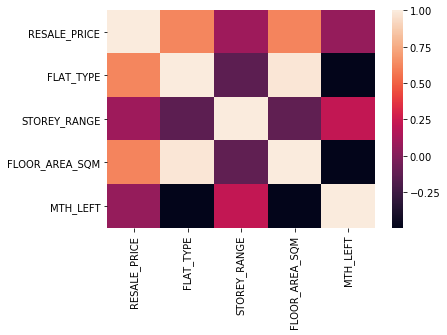

In [74]:
# A simple checkpoint and visualisation.
# What are some insights you see here?
# How much of the insights are due to the assumptions we made above?
import seaborn as sns

df5_test = df5.loc[df5["TOWN"] == "SENGKANG", ["RESALE_PRICE", "FLAT_TYPE", "STOREY_RANGE", "FLOOR_AREA_SQM", "MTH_LEFT"]]

sns.heatmap(df5_test.corr())

In [64]:
from sklearn.feature_selection import SelectKBest, chi2

In [67]:
y = list(df5["RESALE_PRICE"])
X = df5[["FLAT_TYPE", "STOREY_RANGE", "FLOOR_AREA_SQM", "MTH_LEFT"]]

In [68]:
bestfeat = SelectKBest(score_func = chi2, k = 3)
bestfeat.fit(X, y)

ValueError: Unknown label type: (array([232000., 250000., 262000., ..., 838000., 860000., 760000.]),)

#### Outcome of this project  

Before we go into model building, we need to identify what we want to use the model for. To impute missing data? To forecast future data points? To identify overvalue/undervalued flats?  

For the purpose of this exercise guide, we can assume that the observations are independent of one another. However, that isn't strictly true. A 2017 Feb resale of the 1 unit in Bishan Street 11 Blk 123 at a price of 580k (example) will likely influence a similar resale in 2017 Jun. Treating this dataset (rightfully) as time-series data will make it more complicated to learn about feature engineering/selection + model building.  

Hence, the (very) broad assumption is made that in a given time period (2017-2021), resale transactions are independent of each other. This limits our scope of models to mainly regression-type models.

In [39]:
# We only need the year variable. Month is irrelevant (see assumption)
df2["YEAR"] = df2["MONTH"].apply(lambda x: x.split("-")[0])
df2 = df2.drop(columns = "MONTH")
df2.head(2)

,TOWN,FLAT_TYPE,BLOCK,STREET_NAME,STOREY_RANGE,FLOOR_AREA_SQM,FLAT_MODEL,LEASE_COMMENCE_DATE,REMAINING_LEASE,RESALE_PRICE,YEAR
0,ANG MO KIO,2 ROOM,406,ANG MO KIO AVE 10,10 TO 12,44.0,Improved,1979,61 years 04 months,232000.0,2017
1,ANG MO KIO,3 ROOM,108,ANG MO KIO AVE 4,01 TO 03,67.0,New Generation,1978,60 years 07 months,250000.0,2017


In [38]:
df["MONTH"].unique()

yr_df = {}
for yr in range(2017, 2022):
    yr_df[yr] = df.loc[df["MONTH"].str.contains(str(yr)), :]

KeyError: 'MONTH'

In [14]:
for yr in range(2017, 2022):
    print(yr_df[yr]["MONTH"].unique())

['2017-01' '2017-02' '2017-03' '2017-04' '2017-05' '2017-06' '2017-07'
 '2017-08' '2017-09' '2017-10' '2017-11' '2017-12']
['2018-01' '2018-02' '2018-03' '2018-04' '2018-05' '2018-06' '2018-07'
 '2018-08' '2018-09' '2018-10' '2018-11' '2018-12']
['2019-01' '2019-02' '2019-03' '2019-04' '2019-05' '2019-06' '2019-07'
 '2019-08' '2019-09' '2019-10' '2019-11' '2019-12']
['2020-05' '2020-06' '2020-07' '2020-10' '2020-12' '2020-02' '2020-09'
 '2020-01' '2020-03' '2020-04' '2020-08' '2020-11']
['2021-09' '2021-04' '2021-01' '2021-05' '2021-07' '2021-11' '2021-10'
 '2021-02' '2021-03' '2021-06' '2021-08' '2021-12']


In most machine learning models (especially the ones based in Python that we are using), they make the fundamental assumption that numerical features reflect algebraic quantities. For example, given a HDB dataset with 3 towns, Bishan, Sengkang, Clementi. We know that models don't work well with character variables (they prefer numbers). Coding the 3 towns into 1,2,3 respective will imply that:  
Bishan < Sengkang < Clementi  

This doesn't make much sense on a practical basis (based on existing housing market).

Include other datasets? Fed interest rates? Stimulus packages? oversubscription rates of BTO?